## R4ML: Classification Model using SVM

#####    [Alok Singh](https://github.com/aloknsingh/)

### Contents

#### &nbsp;&nbsp;  1. Introduction
#### &nbsp;&nbsp;  2. Problem Statement (Predict whether airline will be Delayed)
#### &nbsp;&nbsp;  3. Extra Data Preparation
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  3.1. Normalization
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  3.2. One Hot Encoding (DummyCoding)
#### &nbsp;&nbsp;  4. Classification using SVM (Support Vector Machine)
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  4.1. SVM Overview?
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  4.2. Train SVM model using R4ML.
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  4.3. Scoring of SVM model on held out data using R4ML.
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  4.4. Summary of classification using SVM.
##### &nbsp;&nbsp;  5. Model-Tuning via Cross-Validation
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  5.1. Cross Validation (CV) overview.
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  5.2. CV for SVM model.
##### &nbsp;&nbsp;  6. Summary and next steps ...

## 1. Introduction

 In this section, we will walk through the general concept of model training and then use the R4ML to conduct Support vector machine classification. We will then train and score the data and conduct cross validation in order to select the best set of hyperparameters.
 
 We talked in part I and II , about how to load R4ML and do some preprocessing with the data. We will use foundation code i.e. the boiler plate code from the previous sections. Here are the links to those notebooks Do visit those section to go in details on each of these steps
 
 * [R4ML BigData Exploration](https://github.com/aloknsingh/ibm_r4ml_biganalytics/blob/master/notebooks/R4ML_Introduction_Exploratory_DataAnalysis.ipynb)
 * [R4ML Data Preparation and Dimension Reduction](https://github.com/aloknsingh/ibm_r4ml_biganalytics/blob/master/notebooks/R4ML_Data_Preprocessing_and_Dimension_Reduction.ipynb)
 
 

In [1]:
library(R4ML)
library(SparkR)

r4ml.session()
# read the airline dataset
airt <- airline
# testing, we just use the small dataset
airt <- airt[airt$Year >= "2007",]
airt <- airline
# testing, we just use the small dataset
airt <- airt[airt$Year >= "2007",]
air_hf <- as.r4ml.frame(airt)

airs <- r4ml.sample(air_hf, 0.1)[[1]]


#
 total_feat <- c(
  "Year", "Month", "DayofMonth", "DayOfWeek", "DepTime","CRSDepTime","ArrTime",
  "CRSArrTime", "UniqueCarrier", "FlightNum", "TailNum", "ActualElapsedTime",
  "CRSElapsedTime", "AirTime", "ArrDelay", "DepDelay", "Origin", "Dest",
  "Distance", "TaxiIn", "TaxiOut", "Cancelled", "CancellationCode",
  "Diverted", "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay",
  "LateAircraftDelay")
#categorical features

#"Year", "Month", "DayofMonth", "DayOfWeek",
cat_feat <- c("UniqueCarrier", "FlightNum", "TailNum", "Origin", "Dest",
  "CancellationCode", "Diverted")

numeric_feat <- setdiff(total_feat, cat_feat)
# these features have no predictive power as it is uniformly distributed i.e less information
unif_feat <- c("Year", "Month", "DayofMonth", "DayOfWeek")
# these are the constant features and we can ignore without much difference in output
const_feat <- c("WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay")

col2rm <- c(unif_feat, const_feat, cat_feat)

rairs <- SparkR::as.data.frame(airs)
airs_names <- names(rairs)
rairs2_names <- setdiff(airs_names, col2rm) 
rairs2 <- rairs[, rairs2_names]

# first we will create the imputation maps
# we impute all the columns
airs_ia <- total_feat
# imputation methods
airs_im <- lapply(total_feat,
               function(feat) {
                 v= if (feat %in% numeric_feat) {"global_mean"} else {"constant"}
                 v
               })
# convert to vector
airs_im <- sapply(airs_im, function(e) {e})
#imputation values
airs_iv <- setNames(as.list(rep("CAT_NA", length(cat_feat))), cat_feat)
na.cols<- setdiff(total_feat, airs_ia)

# we cache the output so that not to re-exe DAG
dummy <- cache(airs)

##

airs_t_res <- r4ml.ml.preprocess(
    airs,
    dummycodeAttrs = c(),
    binningAttrs = c(), numBins=4,
    missingAttrs = airs_ia,
    imputationMethod = airs_im,
    imputationValues = airs_iv,
    omit.na=na.cols, # we remove all the na, this is just the dummy
    recodeAttrs=cat_feat # recode all the categorical features
  )


  # the transformed data frame
  airs_t <- airs_t_res$data
  # the relevant metadata list
  airs_t_mdb <- airs_t_res$metadata

  # cache the transformed data
  dummy <- cache(airs_t)
  ## showDF(airs_t, n = 2)

Warning message:
“WARN[R4ML]: Reloading SparkR”Loading required namespace: SparkR

  _______   _    _    ____    ____  _____
 |_   __ \ | |  | |  |_   \  /   _||_   _|    
   | |__) || |__| |_   |   \/   |    | |      
   |  __ / |____   _|  | |\  /| |    | |   _  
  _| |  \ \_   _| |_  _| |_\/_| |_  _| |__/ | 
 |____| |___| |_____||_____||_____||________| 
 

[R4ML]: version 0.8.0
Warning message:
“no function found corresponding to methods exports from ‘R4ML’ for: ‘collect’”
Attaching package: ‘SparkR’

The following object is masked from ‘package:R4ML’:

    predict

The following objects are masked from ‘package:stats’:

    cov, filter, lag, na.omit, predict, sd, var, window

The following objects are masked from ‘package:base’:

    as.data.frame, colnames, colnames<-, drop, endsWith, intersect,
    rank, rbind, sample, startsWith, subset, summary, transform, union

Warning message:
“WARN[R4ML]:  driver.memory not defined. Defaulting to 2G”Spark package found in SPARK_HOME: /usr/

Launching java with spark-submit command /usr/local/src/spark21master/spark/bin/spark-submit --jars /gpfs/global_fs01/sym_shared/YPProdSpark/user/sa28-9716de71e3ac0f-9ac12ed2939a/R/libs/R4ML/java/SystemML.jar  --driver-memory "2G" sparkr-shell /gpfs/fs01/user/sa28-9716de71e3ac0f-9ac12ed2939a/notebook/tmp/Rtmp2mbv3A/backend_port32b940a07806 


[R4ML]: Default log level will be set to 'INFO'
[R4ML]: To change call r4ml.setLogLevel(NewLevel)
INFO[calc num partitions]: 48 partitions
INFO[as.r4ml.frame]: repartitioning an object of size: 2448976 into 48 partitions
INFO[r4ml.ml.preprocess]: running proxy.omit.na
INFO[r4ml.ml.preprocess]: running proxy.impute
INFO[r4ml.ml.preprocess]: running proxy.normalize
INFO[r4ml.ml.preprocess]: running proxy.binning
INFO[r4ml.ml.preprocess]: running proxy.recode
INFO[r4ml.ml.preprocess]: running proxy.onehot


## 2. Problem Statement (Predict where Airline will be Delayed)

Many real world problems involve analyzing data and predicting certain outcomes. Basic statistics can help one with some of the insights, but to go deeper into predictive analytics, we need stronger and complex mathematical models. For this, there are various kind of machine learning models that are used. R4ML, for example, has a built-in collection of many ML models. Other packages offer ML models, however problems often arise when the data becomes huge and we need scalable machine learning models. R4ML is able to fill this gap.

To better understand this process using R4ML, we will begin by trying out an example prediction problem.

Given the other information about the flights, is it going to get delayed or not? The problem is to find if there is the delay or not. We note that there is the ArrDelay column, which is given to use. Lets assume that it is not available and we are trying to find the airline delay.
 

## 3. Extra Data Preparation.

We saw a few data preparation points in step 2. i.e [R4ML Data Preparation and Dimension Reduction](https://github.com/aloknsingh/ibm_r4ml_biganalytics/blob/master/notebooks/R4ML_Data_Preprocessing_and_Dimension_Reduction.ipynb) ,
Next we will perform two extra pre-processing steps to increase the predictive power of the features.


### 3.1. Normalization 

First lets normalize the scale variable. Because, if we don’t do it, then one variable may have a much larger scale. For example the scale could be inconsistently measured in a mix of seconds and hours.

For the classifier, it will assume that both of them is on 
the same scale and will produce the erroneous result.


In [2]:
col2norm <- setdiff(names(airs_t), cat_feat) #airs_t_norm <- r4ml.normalize(airs_t, col2norm)
airs_t_norm_info <- do.call("r4ml.normalize", unlist(list(airs_t, col2norm))) # extract the r4ml frame from the output
airs_t_norm <- airs_t_norm_info$data
# we can see the normalization outputs
showDF(select(airs_t_norm, c("Distance", "AirTime")), n=2)

+-------------------+-------------------+
|           Distance|            AirTime|
+-------------------+-------------------+
|0.02508771949136634|0.07527970058089166|
|-0.4706745349848571| -0.437196614705027|
+-------------------+-------------------+
only showing top 2 rows


As you can see in the output (which only prints two columns) , the value has been normalized.

### 3.2. One Hot Encoding (DummyCoding)

Next, we will do encoding of the categorical variable of interests.

**Why do this encoding?**

There are two types of categorical variables: ordinal and nominal. Ordinal variables are like the binned continuous variable. Examples include the size of t-shirts, blood pressure ranges and more. However, nominal variable examples differ and include US’ states, airline carriers, airports, etc. By conducting encoding, we will map the above to (1,0), (0,1) and by adding extra features, we will convert categorical, nominal variables into something that can be used by the ML algorithm for classification.”

In [3]:
airs_t_norm_m <- as.r4ml.matrix(airs_t_norm) #these are columns which will be our predictors
oh_cols <- c("Origin", "Dest") # get the one hot encoded matrix
airs_t_oh_info <- r4ml.onehot(airs_t_norm_m, oh_cols) # this contains the one hot encoded r4ml matrix
airs_t_oh <- airs_t_oh_info$data
#this contains the environment which contains the mapping from #original colum to one hot encoded col
airs_t_oh_env <- airs_t_oh_info$metadata
# get the list of new columns which we will use later
oh_exp_cols <- unlist(lapply(oh_cols, function(col) {get(col, envir=airs_t_oh_env)}))

Warning message in `[<-`(`*tmp*`, out_arg, value = <S4 object of class structure("r4ml.matrix", package = "R4ML")>):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, out_arg, value = <S4 object of class structure("r4ml.matrix", package = "R4ML")>):
“implicit list embedding of S4 objects is deprecated”

##### Convert AirDelay to Categorical Variable.

In order to illustrate the classification process, next we will convert our independent variable (i.e **Y == AirDelay**) into a categorical variable.



In [4]:
svm_pred_y <- "Delayed"
airs_t_delayed <- SparkR::mutate( 
    airs_t_oh,
    Delayed = ifelse(airs_t_oh$ArrDelay > 0, 2, 1) # they must be in recoded so we use 1 2
)

## 4. Classification using SVM (Support Vector Machine)

As we have learned, R4ML provides a library with built-in, scalable ML algorithms. But which algorithm should you use? You have the choice of a Support Vector Machine (SVM) or Mlogit (Multiclass logistic regression).

For this example, we will use the SVM. As the first naive approach, we will try to use the canned SVM algorithm provided by the R4ML. Before that lets talk a little about SVM.

Before that lets talk a little about SVM


### 4.1. SVM Overview

##### SVM Intuition
SVM is a supervised classification technique that is listed under supervised learning models. In simple terms, it involves finding the [hyperplane](https://en.wikipedia.org/wiki/Hyperplane) (line in 2D, plane in 3D and hyperplane in higher dimensions) that best separates two classes of points with the maximum margin. (see the picture below)

The SVM is a constrained optimization problem where the margin is maximized, subject to the constraint that it perfectly classifies the data i.e hard margin.(see also this for [optimization formulation](https://en.wikipedia.org/wiki/Support_vector_machine#Linear_SVM) ) 



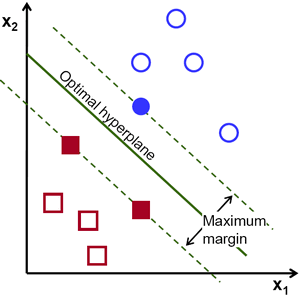

##### Why should SVM be preferred?

First we note that both Logiatic regression as well as SVM can form non linear decision surfaces and can be coupled with the kernel trick. If Logistic regression can be coupled with kernel then why to use SVM?Compare to logistic regression, SVM algorithm has basically advantages in terms of complexity. 

* SVM is found to have better practical performance in most cases.
* SVM is computationally cheaper O(N^2*K) where K is no of support vectors (support vectors are those points that lie on the class margin) where as logistic regression is O(N^3).
* The SVM classifier depends only on a subset of points . Since we need to maximize the distance between the closest points of two classes (aka margin) we need to focus only on a subset of points, unlike logistic regression.

### 4.2.  Train SVM model using R4ML.


In the typical machine learning modelling process, you usually divide the data set into training and test data (hold out) set. Then you train your model on the first data set and see it's accuracy on the latter. We will see the more detailed cross validation steps later but for now, lets follow the simpler steps where we train the model and score it.

##### Split the data set into two

In [5]:
## set up the predicos
svm_scale_predictors_1 <- c("DepTime", "ArrTime", "ActualElapsedTime", "AirTime", "ArrDelay", "DepDelay", "Distance")
svm_nom_predictors_1 <- oh_exp_cols
svm_predictors_1 <- c(svm_scale_predictors_1, svm_nom_predictors_1)

In [6]:
# split the data set into two training and test

svm_inputcols_1 <- c(svm_predictors_1, svm_pred_y)
svm_inputs_df_1 <- select(airs_t_delayed, svm_inputcols_1)

svm_inputs_hm_1 <- as.r4ml.matrix(svm_inputs_df_1)
svm_random_split_1 <- r4ml.sample(svm_inputs_hm_1, c(0.7, 0.3))


svm_train_1 <- svm_random_split_1[[1]]
svm_test_1 <- svm_random_split_1[[2]]

In [7]:
## for R4ML to work properly we have to encode the data type for columns to be one of scale or nominal. Lets change those
# lets create a function to be used in future.
ml.assign.coltypes <- function(hm, pred_y_cols) {
  dt <- SparkR::dtypes(hm)
  nn <- SparkR::colnames(hm)
  dd <- sapply(dt, function(e) {e[[2]]}) # remove
  lookup <- c(int = "scale", double = "scale", string = "string")
  mlt <- unname(lookup[dd])
  mlt[match(pred_y_cols, nn)]<-"nominal"
  ml.coltypes(hm) <- mlt
  hm
}

#apply it to the svm dataset
svm_train_1 <- ml.assign.coltypes(svm_train_1, svm_pred_y)


##### R4ML SVM model training

The next step is to train the scalable machine learning model as follows:


In [8]:
svm_model_1 <- r4ml.svm(Delayed ~ ., data = svm_train_1)

# we can see the weights of some of the
head(collect(svm_model_1@dmlOuts[[ 'weights' ]]))

Warning message in `[<-`(`*tmp*`, out_arg, value = <S4 object of class structure("r4ml.matrix", package = "R4ML")>):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, out_arg, value = <S4 object of class structure("r4ml.matrix", package = "R4ML")>):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, out_arg, value = <S4 object of class structure("r4ml.matrix", package = "R4ML")>):
“implicit list embedding of S4 objects is deprecated”

weights,weights
-0.05530476,0.05530476
-0.13609632,0.13609632
-1.05036938,1.05036938
0.39283297,-0.39283297
-5.95697299,5.95697299
-1.49537109,1.49537109


### 4.3.  Scoring of SVM model on held out data using R4ML 
Let's check out the accuracy on the hold out data.



In [9]:
svm_preds_1 <- predict(svm_model_1, svm_test_1)
svm_preds_1$accuracy

INFO[predict.r4ml.svm]: Predicting labels using given SVM model/gpfs/fs01/user/sa28-9716de71e3ac0f-9ac12ed2939a/R4ML/scratch_workspace/r4ml.svm/1d019fe3-a3cf-433d-be48-1b50fca88a44/on data
INFO[r4ml.ml.checkModelFeaturesMatchData]: Ensuring the consistency between model and data features
Warning message in `[<-`(`*tmp*`, out_arg, value = <S4 object of class structure("r4ml.matrix", package = "R4ML")>):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, out_arg, value = <S4 object of class structure("r4ml.matrix", package = "R4ML")>):
“implicit list embedding of S4 objects is deprecated”INFO[packagePredictSvmOutput]: Packaging output of svm predict


[1] 94.34343

##### Analysing the prediction

As we know, accuracy in classification models can be misleading. Hence apart from accuracy, prediction also contains the actual confusion 
matrix and predicted scores.

A [Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is just the snapshot picture of the real performance of the classification model as shown in the following picture.


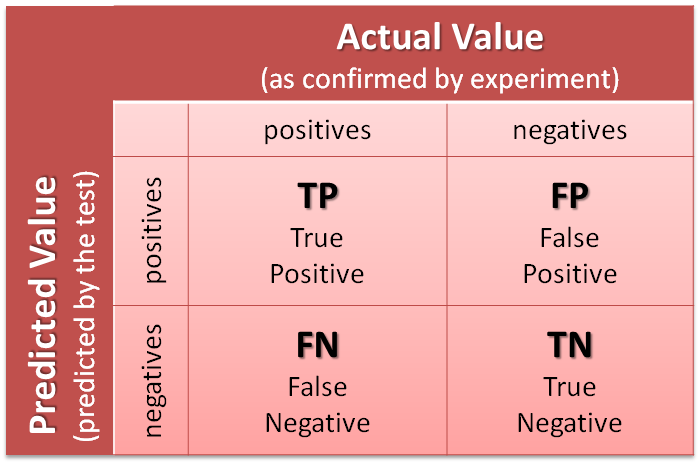

##### Plotting the confusion matrix

Let's see how a R4ML confusion matrix looks. (**Note that the following plot has been rotated on the middle vertical axis to follow R's ggplot**).

We observe in the following plot that the TP and TN is very high and FP and FN are low. This means we can be more confident of our model than just the accuracy-based analysis.


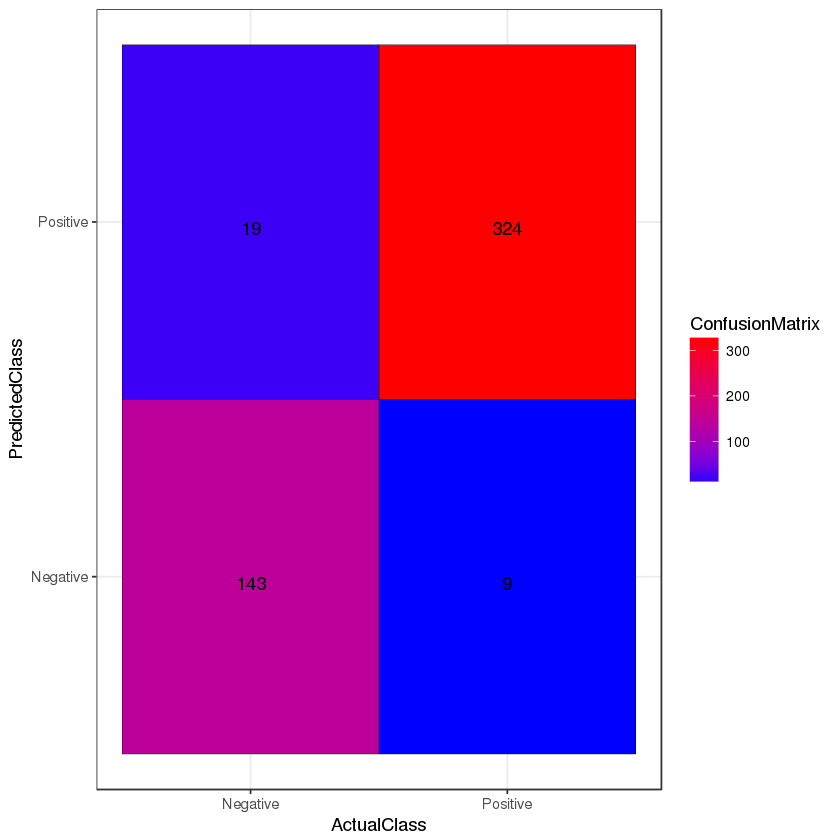

In [11]:
## lets see how our models' confusion matrix look like

# get the confusion marix
svm_preds_cm <- as.data.frame(svm_preds_1$ctable)

# print it

one <- "Positive"
zero <- "Negative"

ActualClass <- factor(c(one, one, zero, zero))
PredictedClass <- factor(c(one, zero, one, zero))

# get the parts of CM
TP <- svm_preds_cm[[1]][[1]]
TN <- svm_preds_cm[[2]][[2]]
FN <- svm_preds_cm[[2]][[1]]
FP <- svm_preds_cm[[1]][[2]]
ConfusionMatrix <- c(TP, FP, FN, TN)

# create
svm_preds_cm_df <- data.frame(ActualClass, PredictedClass,ConfusionMatrix )

# plot
library(ggplot2)
ggplot(data =  svm_preds_cm_df, mapping = aes(x = ActualClass, y = PredictedClass)) +
  geom_tile(aes(fill = ConfusionMatrix), colour = "black") +
  geom_text(aes(label = sprintf("%1.0f", ConfusionMatrix)), vjust = 1) +
  scale_fill_gradient(low = "blue", high = "red") +
  theme_bw() + theme(legend.position = "right")


#### Scores

We can also see the predicted scores. The higher the score, the higher the margin and the better or more confident we are of the prediction.


In [12]:

head(svm_preds_1$scores)


class:1,class:2
2.5279552,-2.5279552
-18.4705711,18.4705711
-9.3611200,9.3611200
0.6675133,-0.6675133
-0.4498902,0.4498902
0.5542062,-0.5542062


 ### 4.4. Summary of classification using SVM.
 
 
 We saw:
 
  * How to formulate the problem in terms of classification task.

  * Use R4ML to train the scalable SVM model.
 
  * Predict the scores on the held out data.
 
  * Analyse the prediction on various perspective.
 

## 5. Model-Tuning via Cross-Validation



### 5.1. Cross-Validation Overview

Many models have important parameters which cannot be directly estimated from the data. For example, in the SVM classification problem, to avoid overfitting, it should be adjusted using the tuning parameter lambda. The question is: what should the value be?

There are different approaches to searching for the best parameters. A general approach that can be applied to almost any model is to define a set of candidate values, generate reliable estimates of model utility across the candidate values, then choose the optimal settings. A flowchart of this process is shown in the following figure:



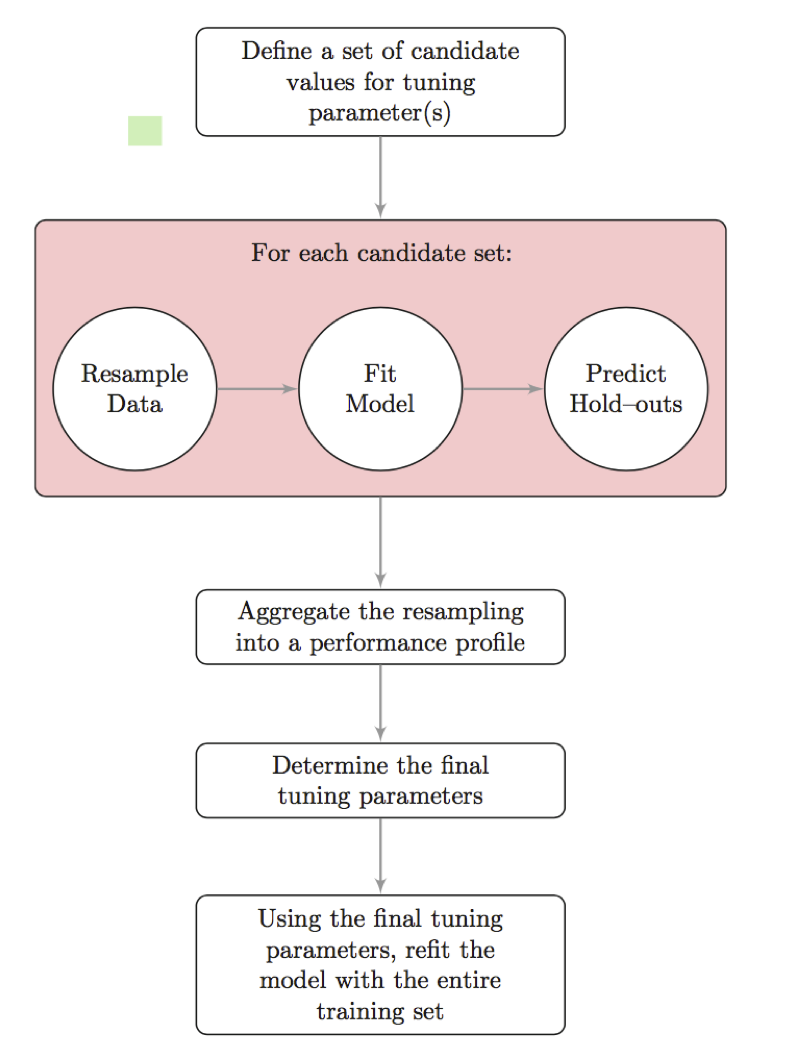


* Once a candidate set of parameter values has been selected, then we must obtain trustworthy estimates of model performance. The performance on the hold-out samples is then aggregated into a performance profile which is then used to determine the final tuning parameters. We then build a final model with all of the training data using the selected tuning parameters.

* A more difficult problem is obtaining trustworthy estimates of model performance for these candidate models. As previously discussed, the apparent error rate can produce extremely optimistic performance estimates. A better approach is to test the model on samples that were not used for training.

* Evaluating the model on a test set is the obvious choice, but, to get reasonable precision of the performance values, the size of the test set may need to be large.


Once we know this, lets evaluate our model with respect to the grid search. While the the k-fold cross-validation could be applied here, we will use the 2-fold cross-validation.


### 5.2. CV for SVM model.

Here is the R code for achieving the same.
 
 

In [14]:
lambdas <- c(0, 0.5, 1 , 1.5, 2, 2.5, 3)
lambdas <- c(0, 0.1, 0.4, 0.7, 1, 2, 3, 4, 5)
svm_models <- list()
svm_preds <- list()
for (i in 1:length(lambdas)) {

  lambda <- lambdas[i]

  svm_model_i <- r4ml.svm(Delayed ~ ., data = svm_train_1,   lambda=lambda)

  svm_preds_i <- predict(svm_model_i, svm_test_1)

  svm_models[[length(svm_models) + 1]] <- svm_model_i

  svm_preds[[length(svm_preds) + 1]] <- svm_preds_i


}


Warning message in `[<-`(`*tmp*`, out_arg, value = <S4 object of class structure("r4ml.matrix", package = "R4ML")>):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, out_arg, value = <S4 object of class structure("r4ml.matrix", package = "R4ML")>):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, out_arg, value = <S4 object of class structure("r4ml.matrix", package = "R4ML")>):
“implicit list embedding of S4 objects is deprecated”INFO[predict.r4ml.svm]: Predicting labels using given SVM model/gpfs/fs01/user/sa28-9716de71e3ac0f-9ac12ed2939a/R4ML/scratch_workspace/r4ml.svm/036be788-ae26-40be-92ec-026c944035d1/on data
INFO[r4ml.ml.checkModelFeaturesMatchData]: Ensuring the consistency between model and data features
Warning message in `[<-`(`*tmp*`, out_arg, value = <S4 object of class structure("r4ml.matrix", package = "R4ML")>):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*

In [15]:

#now check which one gives us the best accuracy
svm_accs <- sapply(svm_preds, function(p) {p$accuracy})
best_fit_idx <- which(svm_accs == max(svm_accs))
lambdas[best_fit_idx]


[1] 0.1 0.4

In [16]:

# here are all the accuracies
# svm_preds[[best_fit_idx]]$accuracy
svm_preds

[[1]]
[[1]]$accuracy
[1] 93.93939

[[1]]$ctable
  confusion_mat confusion_mat
1           321            18
2            12           144

[[1]]$scores
SparkDataFrame[class:1:double, class:2:double]


[[2]]
[[2]]$accuracy
[1] 95.15152

[[2]]$ctable
  confusion_mat confusion_mat
1           324            15
2             9           147

[[2]]$scores
SparkDataFrame[class:1:double, class:2:double]


[[3]]
[[3]]$accuracy
[1] 95.15152

[[3]]$ctable
  confusion_mat confusion_mat
1           326            17
2             7           145

[[3]]$scores
SparkDataFrame[class:1:double, class:2:double]


[[4]]
[[4]]$accuracy
[1] 94.54545

[[4]]$ctable
  confusion_mat confusion_mat
1           325            19
2             8           143

[[4]]$scores
SparkDataFrame[class:1:double, class:2:double]


[[5]]
[[5]]$accuracy
[1] 94.34343

[[5]]$ctable
  confusion_mat confusion_mat
1           324            19
2             9           143

[[5]]$scores
SparkDataFrame[class:1:double, class:2:doubl

## 6. Summary and next steps ...

In this section, we saw: 

- The end to end data processing pipeline for scalable machine learning flow using R4ML, a hybrid tool on the top of Apache SparkR and Apache SystemML.

- How we can build a classification Support vector model for predicting the Arrival delay of airline. 

- In the end we used the classic model tuning to select the best set of parameters.
